In [1]:

from scipy.io import mmread
import networkx as nx
import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
ROOT_FOLDER = Path("..")
DATA_FOLDER = ROOT_FOLDER / "data"
OUTPUT_FOLDER = ROOT_FOLDER / "out"

os.makedirs(OUTPUT_FOLDER, exist_ok=True)

In [3]:
matrix = mmread(DATA_FOLDER / "econ-poli-large.mtx")
G = nx.DiGraph()

In [4]:
rows, cols, data = matrix.row, matrix.col, matrix.data

In [5]:
for source, target, weight in zip(rows, cols, data):
    G.add_edge(source + 1, target + 1, weight=weight)

In [6]:
nx.write_gexf(G, path=OUTPUT_FOLDER / "project.gexf")

In [7]:
df = pd.read_csv(DATA_FOLDER / "Project.csv")
df.head()

,Id,Label,indegree,outdegree,Degree,eigencentrality,clustering,modularity_class,stat_inf_class,weighted indegree,weighted outdegree,Weighted Degree,Eccentricity,closnesscentrality,harmonicclosnesscentrality,betweenesscentrality,componentnumber,strongcompnum
0,1,1,1,145,146,0.005391,0.009052,0,35,1.0000,-66.63240,-65.63240,11,0.139220,0.161498,0.000000,0,15465
1,2,2,4,4,8,0.108882,0.190476,1,0,0.0000,-0.09800,-0.09800,5,0.378486,0.414386,4632.833333,0,11457
2,1761,1761,2,188,190,0.171701,0.006855,2,27,0.9497,-124.02205,-123.07235,10,0.227935,0.267383,101354.921429,0,15053
3,7097,7097,4,20,24,0.092854,0.051383,3,0,0.1734,-11.55560,-11.38220,6,0.341317,0.404605,10605.850000,0,11458
4,3,3,5,35,40,0.093512,0.027665,4,0,-0.0000,-29.06400,-29.06400,1,1.000000,1.000000,3570.000000,0,11456


In [8]:
df.columns

Index(['Id', 'Label', 'indegree', 'outdegree', 'Degree', 'eigencentrality',
       'clustering', 'modularity_class', 'stat_inf_class', 'weighted indegree',
       'weighted outdegree', 'Weighted Degree', 'Eccentricity',
       'closnesscentrality', 'harmonicclosnesscentrality',
       'betweenesscentrality', 'componentnumber', 'strongcompnum'],
      dtype='object')

In [9]:
df.Degree.max()

494

In [10]:
num_nodes = len(G.nodes)
num_edges = len(G.edges)
num_edges / (num_nodes * (num_nodes - 1))

0.00013635105304741964

Průměrný shlukovací koeficient (CC): 0.456


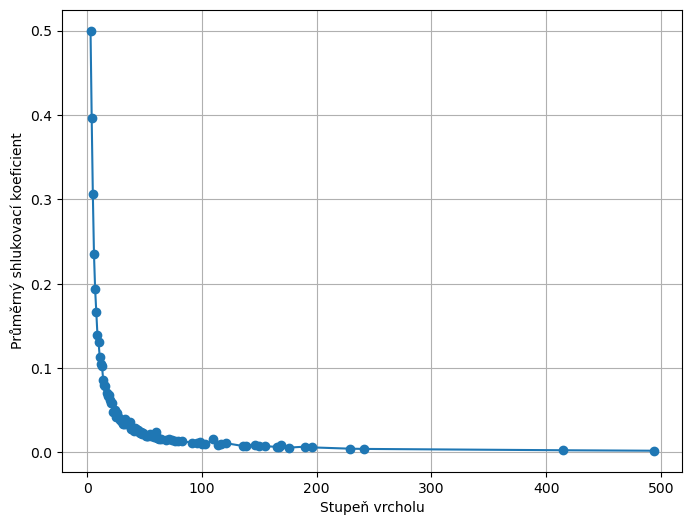

In [11]:
average_clustering_coefficient = df['clustering'].mean()
print(f"Průměrný shlukovací koeficient (CC): {average_clustering_coefficient:.3f}")

# Shlukovací efekt - průměrný CC pro vrcholy daného stupně
degree_clustering = df.groupby('Degree')['clustering'].mean()

# Vizualizace shlukovacího efektu
plt.figure(figsize=(8, 6))
plt.plot(degree_clustering.index, degree_clustering.values, marker='o', linestyle='-')
plt.xlabel('Stupeň vrcholu')
plt.ylabel('Průměrný shlukovací koeficient')
plt.grid()
plt.show()

Počet souvislých komponent: 15466
Distribuce velikostí komponent:
strongcompnum
15053    90
4034      4
11878     4
11458     3
4861      2
         ..
20        1
19        1
18        1
17        1
15440     1
Name: count, Length: 15466, dtype: int64


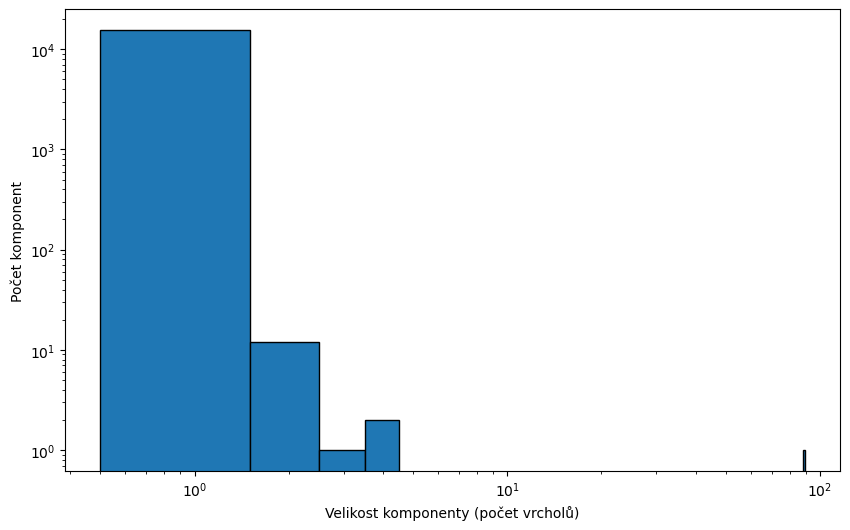

In [12]:

# Počet souvislých komponent
unique_components = df['strongcompnum'].nunique()
print(f"Počet souvislých komponent: {unique_components}")

# Distribuce velikostí komponent
component_distribution = df['strongcompnum'].value_counts()
print("Distribuce velikostí komponent:")
print(component_distribution)

plt.figure(figsize=(10, 6))
plt.hist(component_distribution, bins=range(1, component_distribution.max() + 1), edgecolor='black', align='left')
plt.xscale("log")
plt.yscale("log")
plt.xlabel('Velikost komponenty (počet vrcholů)')
plt.ylabel('Počet komponent')
plt.show()



In [13]:
df.sort_values(by=['closnesscentrality', 'harmonicclosnesscentrality', 'betweenesscentrality'], ascending=False)[['Degree','closnesscentrality', 'harmonicclosnesscentrality', 'betweenesscentrality']].head(5)

,Degree,closnesscentrality,harmonicclosnesscentrality,betweenesscentrality
1770,494,1.0,1.0,50960.000000
10056,117,1.0,1.0,11172.000000
7937,100,1.0,1.0,9340.666667
2789,96,1.0,1.0,9016.000000
2622,63,1.0,1.0,5696.500000


In [14]:
louvain_communities = nx.community.louvain_communities(G)
lc_np = np.array([len(community) for community in louvain_communities])

np.min(lc_np), np.max(lc_np), np.mean(lc_np)

(np.int64(1), np.int64(3911), np.float64(1.3388635777529443))

In [15]:
len(louvain_communities)

11633

In [16]:
nx.community.modularity(G, louvain_communities)

np.float64(7.610406350227211)

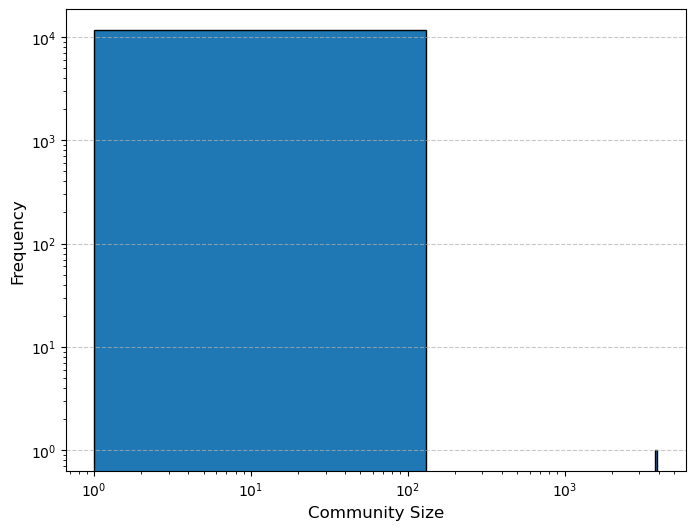

In [17]:
community_sizes = [len(community) for community in louvain_communities]

# Plot the histogram
plt.figure(figsize=(8, 6))
plt.hist(community_sizes, bins=30, edgecolor='black')
plt.xlabel("Community Size", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xscale("log")
plt.yscale("log")
plt.show()

In [18]:
for i, community in enumerate(louvain_communities):
    for node in community:
        G.nodes[node]['louvain_community'] = i

In [19]:
nx.write_gexf(G, path=OUTPUT_FOLDER / "project_louvain.gexf")

In [49]:
def recursive_kernighan_lin(graph, num_communities):
    """Rekurzivní rozdělení grafu pomocí Kernighan-Lin na zadaný počet komunit."""
    # Počáteční rozdělení grafu
    communities = [set(graph.nodes())]  # Start with the full graph

    # Rekurzivní dělení, dokud nedosáhneme požadovaného počtu komunit
    while len(communities) < num_communities:
        # Najdi největší komunitu k rozdělení
        largest_community = max(communities, key=len)
        communities.remove(largest_community)

        # Aplikuj Kernighan-Lin na největší komunitu
        subgraph = graph.subgraph(largest_community)
        set1, set2 = nx.community.kernighan_lin_bisection(subgraph)

        # Přidej nové komunity
        communities.append(set1)
        communities.append(set2)

    return communities

undirected_g = G.to_undirected()

num_communities = 8
kernighan_lin_bisection = recursive_kernighan_lin(undirected_g, num_communities)

In [50]:
lc_np = np.array([len(community) for community in kernighan_lin_bisection])
np.min(lc_np), np.max(lc_np), np.mean(lc_np)

(np.int64(1946), np.int64(1947), np.float64(1946.875))

In [51]:
nx.community.modularity(G, kernighan_lin_bisection)

np.float64(5.689170369318032)

In [52]:
len(kernighan_lin_bisection)

8

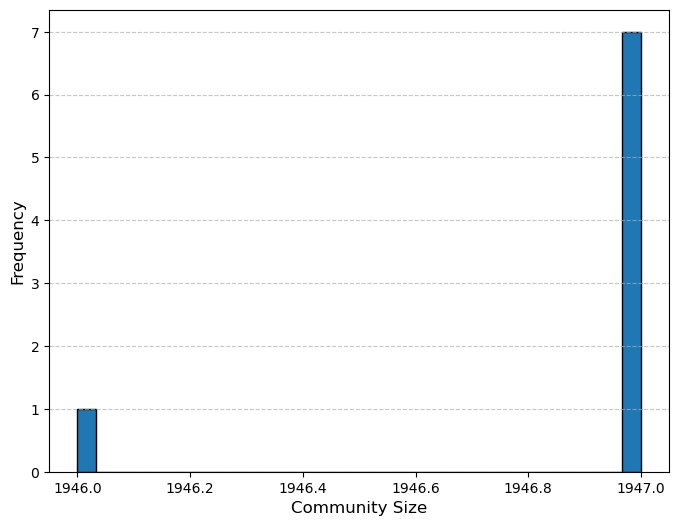

In [53]:
community_sizes = [len(community) for community in kernighan_lin_bisection]

# Plot the histogram
plt.figure(figsize=(8, 6))
plt.hist(community_sizes, bins=30, edgecolor='black')
plt.xlabel("Community Size", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
# plt.xscale("log")
# plt.yscale("log")
plt.show()

In [54]:
for i, community in enumerate(kernighan_lin_bisection):
    for node in community:
        G.nodes[node]['kernighan_lin_bisection'] = i

In [55]:
nx.write_gexf(G, path=OUTPUT_FOLDER / "project_kernighan_lin_bisection.gexf")